# 네이버 영화 리뷰 감성 분석

## 1. 데이터 준비와 확인

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7fcc2bf661d0>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

## 2. 데이터로더 구성

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    
    return result

In [ ]:
def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # Nan 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중.....
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
    # [1:]를 통해 <BOS> 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentenes(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

## 3. 모델 구성을 위한 데이터 분석 및 가공

In [ ]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 예를 들어 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/ len(num_tokens)))

문장길이 평균 : 15.96938143432699
문장길이 최대 : 116
문장길이 표준편차 : 12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
# 패딩 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


In [ ]:
vocab_size = 10000
word_vector_dim = 200

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련

In [ ]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 100

history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

In [ ]:
results = model.evaluate(x_test, y_test, verbose=2)

In [ ]:
print(results)

[1.7903430461883545, 0.8173810243606567]


## 6. loss, accuracy 그래프 시각화

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

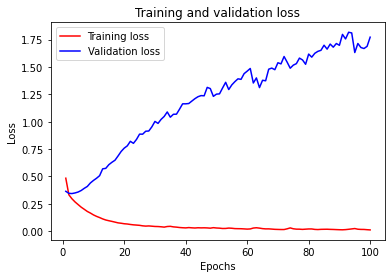

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

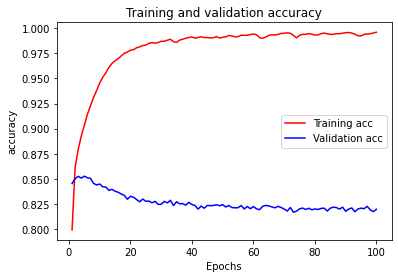

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

-------------------------

# Proj : 네이버 영화 리뷰 감성 분류에 SentencePiece 적용해보기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-03-18 05:05:57--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-03-18 05:05:57--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [ ]:
import sentencepiece as spm

...전처리...?

In [ ]:
path_to_file = './korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size :", len(raw))

Data Size : 94123


In [ ]:
print(type(raw))

<class 'list'>


In [ ]:
min_len = 999
max_len = 0
sum_len = 0
print("Data Size :", len(raw))

for sen in raw:
  lenght = len(sen)
  if min_len > lenght: min_len = lenght
  if max_len < lenght: max_len = lenght
  sum_len += lenght

print('문장의 최단 길이 : ',min_len)
print('문장의 최장 길이 : ',max_len)
print('문장의 평균 길이 : ',sum_len//len(raw))

Data Size : 94123
문장의 최단 길이 :  1
문장의 최장 길이 :  377
문장의 평균 길이 :  60


In [ ]:
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [ ]:
min_ren = 999
max_len = 0
sum_len = 0


cleaned_corpus = list(set(raw))

for sen in cleaned_corpus:
  lenght = len(sen)
  if min_len > lenght: min_len = lenght
  if max_len < lenght: max_len = lenght
  sum_len += lenght
  
print("Data Size :", len(cleaned_corpus))
print('문장의 최단 길이 : ',min_len)
print('문장의 최장 길이 : ',max_len)
print('문장의 평균 길이 : ',sum_len//len(cleaned_corpus))

Data Size : 77591
문장의 최단 길이 :  1
문장의 최장 길이 :  377
문장의 평균 길이 :  64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


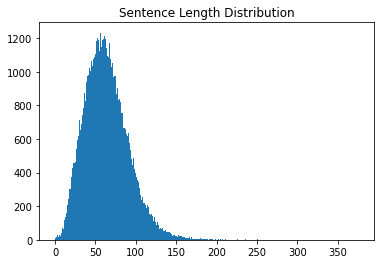

In [ ]:
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width= 1.0)
plt.title("Sentence Length Distribution")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Text(0.5, 1.0, 'S')

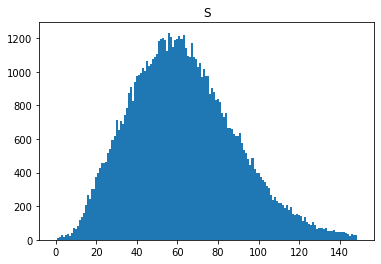

In [ ]:
min_ren = 0
max_len = 150

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("S")

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
import tensorflow as tf
import os
temp_file =  './korean-english-park.train.ko.temp'

# vacab size
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 정제했던 corpus를 활용
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)


!ls -l korean_spm*

-rw-r--r-- 1 root root 376761 Mar 18 05:06 korean_spm.model
-rw-r--r-- 1 root root 146209 Mar 18 05:06 korean_spm.vocab


In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
# sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1957 5667    5    4 7975 1991    3    0    0    0    0    0    0    0]
 [ 107 1639  101    4    0  416   11    4   14    0 1977    3    3    3]]


In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()
test_data.head() #영어 1번째에 존재

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
mecab = Mecab()

def mecab_split(sentence):
  result = mecab.morphs(sentence)
  return result

mecab_corpus = []
for kor in filtered_corpus:
  mecab_corpus.append(mecab_split(kor))

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
print(train_data['document'].nunique())
print(len(train_data['document']) )

# Null값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
# Null값이 존재하는지 확인
print(train_data.isnull().values.any())

146182
149995
False


In [ ]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# Nan 결측치 제거
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

In [ ]:
print(train_data['document'].nunique())
print(len(train_data['document']) )

# Null값이 존재하는 행 제거
train_data = train_data.dropna(how='any')
# Null값이 존재하는지 확인
print(train_data.isnull().values.any())

146182
146182
False


In [ ]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [ ]:
test_data['document'] #영어...근데 지우는 법 모름 (한방에... 리플레이스인가...) 

0                                                      굳 ㅋ
1                                     GDNTOPCLASSINTHECLUB
2                   뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                         지루하지는 않은데 완전 막장임... 돈주고 보기에는....
4        3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
                               ...                        
49995            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
49996         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
49997                   그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
49998       절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네
49999                                           마무리는 또 왜이래
Name: document, Length: 49157, dtype: object

In [ ]:
# sp_tokenize(s, corpus) 사용예제
train, train_word_index, train_index_word = sp_tokenize(s, train_data['document'])
test, test_word_index, test_index_word = sp_tokenize(s, test_data['document'])

In [ ]:
display(train_data.head())
display(test_data.head())
display(train[1])
display(test[1])

In [ ]:
x_val = x_train[:50000]
y_val = train_data['label'][:50000]



partial_x_train = x_train[50000:]
partial_y_train = train_data['label'][50000:]
print(type(partial_x_train), type(partial_y_train))

<class 'list'> <class 'pandas.core.series.Series'>


In [ ]:
vocab_size = 10000
word_vector_dim = 200

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 200)         2000000   
                                                                 
 lstm_21 (LSTM)              (None, None, 32)          29824     
                                                                 
 dropout_12 (Dropout)        (None, None, 32)          0         
                                                                 
 lstm_22 (LSTM)              (None, None, 32)          8320      
                                                                 
 dropout_13 (Dropout)        (None, None, 32)          0         
                                                                 
 dense_14 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 2,038,177
Trainable params: 2,038,177
N

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 100

history = model.fit(train, train_data['label'], epochs=epochs, batch_size=512, validation_data=(test, test_data['label']), verbose=1)

Epoch 1/100
286/286 [==============================] - 34s 104ms/step - loss: 0.5021 - accuracy: 0.7458 - val_loss: 0.4332 - val_accuracy: 0.8017
Epoch 2/100
286/286 [==============================] - 29s 100ms/step - loss: 0.4076 - accuracy: 0.8141 - val_loss: 0.4066 - val_accuracy: 0.8113
Epoch 3/100
286/286 [==============================] - 29s 101ms/step - loss: 0.3784 - accuracy: 0.8272 - val_loss: 0.3958 - val_accuracy: 0.8185
Epoch 4/100
286/286 [==============================] - 29s 100ms/step - loss: 0.3548 - accuracy: 0.8401 - val_loss: 0.3895 - val_accuracy: 0.8193
Epoch 5/100
286/286 [==============================] - 29s 101ms/step - loss: 0.3368 - accuracy: 0.8500 - val_loss: 0.3808 - val_accuracy: 0.8262
Epoch 6/100
286/286 [==============================] - 29s 101ms/step - loss: 0.3214 - accuracy: 0.8588 - val_loss: 0.3846 - val_accuracy: 0.8277
Epoch 7/100
286/286 [==============================] - 29s 101ms/step - loss: 0.3081 - accuracy: 0.8661 - val_loss: 0.3896 -

KeyboardInterrupt: ignored

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 100

history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

ValueError: ignored

 # inference

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)

  #new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화

  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

  encoded = sp_tokenize(s, new_sentence)
  #encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩

  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(korean_spm.model.predict(pad_new)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
# sp_tokenize(s, corpus) 사용예제
train, train_word_index, train_index_word = sp_tokenize(s, train_data['document'])

In [ ]:
print(s)

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7fcc20bce4b0> >


In [ ]:
sentiment_predict('재미없어')

TypeError: ignored